In [1]:
import ROC as roc_maker

import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
def integral(y,x,bins):
    x_min=x
    s=0
    for i in np.where(bins>x)[0][:-1]:
#        s=s+y[i]*(bins[i+1]-bins[i])
#        print(i,s)
        s=s+y[i]*(bins[i+1]-bins[i])
    return s

In [14]:
class ROC:
    def __init__(self,MVA_model,X_test_scaled,y_test,MVA_model_name):
#        noise_score_1=MVA_model.predict(X_test_scaled[np.where(y_test==1)])[:,0]
#        noise_score_0=MVA_model.predict(X_test_scaled[np.where(y_test==0)])[:,0]
        signal_score_1=MVA_model.predict(X_test_scaled[np.where(y_test==1)])[:,1]
        signal_score_0=MVA_model.predict(X_test_scaled[np.where(y_test==0)])[:,1]
        
        Nbins=1000
        y_signal,bins_1,_=plt.hist(signal_score_1, bins=Nbins, alpha=0.8, label='Signal')#, density=True
        y_bkg,bins_0,_=plt.hist(signal_score_0, bins=Nbins, alpha=0.8, label='Background')#, density=True
        plt.yscale('log')
        plt.legend()
        plt.xlabel('MVA score')
        plt.savefig(MVA_model_name+'_score.pdf')
        plt.show()

        Nsignal=integral(y_signal,0,bins_1)
        Nbkg=integral(y_bkg,0,bins_0)
        signal_eff=np.array([])
        bkg_eff=np.array([])
        y_s=0
        y_n=0
        for i in range(0,Nbins+1):
            x=i/Nbins
            y_s=integral(y_signal,x,bins_1)/Nsignal
            y_n=integral(y_bkg,x,bins_0)/Nbkg
            signal_eff=np.append(y_s,signal_eff)
            bkg_eff=np.append(y_n,bkg_eff)

        #Area=round(1000*integral(signal_eff,0)/Nbins)/1000
        Area=round(1000*abs(integral(signal_eff,0,bkg_eff)))/1000
        
        lab='Area: '+str(Area)
        plt.plot(bkg_eff,signal_eff,label=lab)
        plt.plot([0,1],[0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #plt.xlim([0.001,1])
        #plt.yscale('log')
        plt.title('ROC curve')
        plt.legend()
        plt.savefig('ROC_'+MVA_model_name+'.pdf')
        plt.show()

        WP=[0.90,0.94,0.97,0.99]
        rej=1./bkg_eff
        WP_idx=[np.where(np.abs(signal_eff-WP[i])==np.min(np.abs(signal_eff-WP[i])))[0][0] for i in range(0,len(WP))]
        #rej[WP_idx]
        WP_rej=[str(round(10*rej[WP_idx[i]])/10) for i in range(0,len(WP))]
        print(WP_rej)

        plt.plot(signal_eff,rej)
        for i in range(0,len(WP)):
            plt.axvline(x=WP[i],color='Red',linestyle='dashed',label='Bkg Rejection @ '+str(WP[i])+' WP: '+WP_rej[i])
        plt.xlabel('Signal efficiency')
        plt.ylabel('Background rejection')
        plt.xlim([0.75,1])
        plt.yscale('log')
        plt.title('ROC curve')
        plt.legend()
#        plt.savefig('rejection_ROC_'+MVA_model_name+'.pdf')
        plt.show()
        
        self.auc=Area
        self.signal_eff=signal_eff
        self.bkg_eff=bkg_eff
        self.bkg_rej=rej
        self.WP=WP
        self.WP_rej=WP_rej

In [4]:
mode='VariableCone_m/'
path='../PKL/Zprime'+mode

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU'),tf.config.list_physical_devices('CPU')

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')])

In [6]:
path='../PKL/Zprime'+mode+'wrongscalingJet/'

In [7]:
NN_model_name='NN_base'
#PCANN_model_name='PCANN_base'

In [8]:
NN=tf.keras.models.load_model(path+'models/'+NN_model_name)
#PCANN=tf.keras.models.load_model(path+'models/'+PCANN_model_name)

In [9]:
columns_list=columns_list=np.array(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac'])
#X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dp_f.retrieve_dataset(path_NN)
X_train_scaled=np.genfromtxt(path+"X_train.csv",delimiter=',')
X_test_scaled=np.genfromtxt(path+"X_test.csv",delimiter=',')
y_train=np.genfromtxt(path+"y_train.csv",delimiter=',')
y_train_cat=np.genfromtxt(path+"y_train_cat.csv",delimiter=',')
y_test=np.genfromtxt(path+"y_test.csv",delimiter=',')
y_test_cat=np.genfromtxt(path+"y_test_cat.csv",delimiter=',')

In [11]:
NN.evaluate(X_test_scaled,y_test_cat)

413/413 [==============================] - 1s 3ms/step - loss: 0.3316 - accuracy: 0.8434


[0.33163779973983765, 0.8433999419212341]

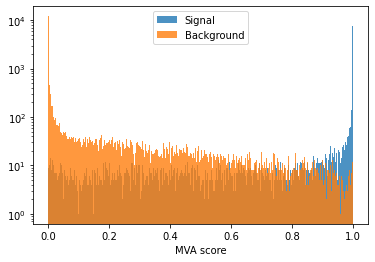

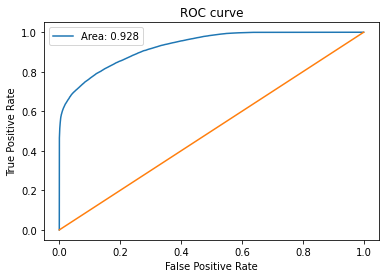

<ipython-input-14-c632b0344331>:46: RuntimeWarning: divide by zero encountered in true_divide
  rej=1./bkg_eff


['3.7', '2.8', '2.2', '1.9']


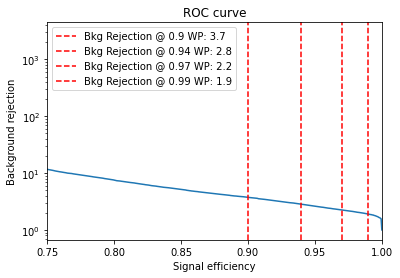

In [15]:
NN_base=ROC(NN,X_train_scaled,y_train,NN_model_name)